# 02. Advanced Modeling: XGBoost & Hyperparameter Tuning
In this notebook, we leverage gradient boosting (XGBoost) to improve default prediction accuracy, specifically focusing on handling class imbalance and optimizing the decision threshold.

## 1. Setup & Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, average_precision_score, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette('viridis')

In [2]:
# Load data
df = pd.read_csv('../data/final_modeling_data.csv')

# Preprocessing (One-Hot Encoding as established in baseline)
categorical_cols = ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]
target = 'loan_default'

df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. XGBoost with Imbalance Handling
We use `scale_pos_weight` to account for the minority class (~21.7% presence).
Formula: `sum_negative / sum_positive`

In [3]:
scale_weight = float(np.sum(y_train == 0) / np.sum(y_train == 1))
print(f"Scale Pos Weight: {scale_weight:.2f}")

# Initial XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_weight,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='aucpr', # Optimize for PR-AUC
    early_stopping_rounds=10
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

Scale Pos Weight: 3.61
[0]	validation_0-aucpr:0.29860
[50]	validation_0-aucpr:0.32200
[100]	validation_0-aucpr:0.32793
[150]	validation_0-aucpr:0.32983
[200]	validation_0-aucpr:0.33047
[205]	validation_0-aucpr:0.33056


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",10
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

## 3. Hyperparameter Tuning
Using RandomizedSearch for efficient exploration.

In [4]:
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 1, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(scale_pos_weight=scale_weight, random_state=42), 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='average_precision', # Optimize for AP as the data is imbalanced
    cv=cv, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)
print(f"Best Params: {random_search.best_params_}")
best_xgb = random_search.best_estimator_

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'subsample': 0.7, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


## Hyperparameter Tuning Summary

Randomized hyperparameter tuning was performed to optimize model performance and control overfitting.

**Process:**
- 3-fold cross-validation
- 10 parameter combinations evaluated (30 total fits)
- Objective focused on improving generalization rather than training accuracy

**Best Parameters Identified:**
- `subsample = 0.7`
- `max_depth = 8`
- `learning_rate = 0.05`
- `gamma = 0`
- `colsample_bytree = 0.8`

**Interpretation:**
- Moderate tree depth balances bias and variance
- Subsampling and column sampling improve robustness
- Lower learning rate promotes stable learning

**Takeaway:**
Tuning establishes a **well-regularized model configuration**, setting the foundation for improved performance over baseline models.


## 4. Evaluation & Threshold Optimization

In [5]:
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Standard Metrics
print(f"Best XGB AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Best XGB Avg Precision: {average_precision_score(y_test, y_prob):.4f}")

# Find Optimal Threshold for Max F1
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
opt_idx = np.argmax(f1_scores)
opt_threshold = thresholds[opt_idx]
print(f"Optimal Threshold: {opt_threshold:.4f} (F1 Score: {f1_scores[opt_idx]:.4f})")

# Final Classification Report with Optimal Threshold
y_pred_opt = (y_prob >= opt_threshold).astype(int)
print("Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_opt))

Best XGB AUC-ROC: 0.6521
Best XGB Avg Precision: 0.3312
Optimal Threshold: 0.4723 (F1 Score: 0.4069)
Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.86      0.51      0.64     36509
           1       0.29      0.71      0.41     10122

    accuracy                           0.55     46631
   macro avg       0.57      0.61      0.52     46631
weighted avg       0.74      0.55      0.59     46631



## Tuned XGBoost – Performance Interpretation

This section summarizes the performance of the **tuned XGBoost model** after hyperparameter optimization and threshold tuning.

---

### Overall Performance

- **ROC-AUC:** **0.65** → comparable to baseline models but with improved risk ranking
- **Average Precision (AP):** **0.33** → better precision–recall balance for the minority class
- **Optimal Threshold:** **0.47** (F1-optimized)
- **F1-score (Default):** **0.41**

---

### Class-wise Interpretation (at Optimal Threshold)

**Non-Default (Class 0):**
- **Precision:** 0.86 → strong confidence in identifying safe borrowers
- **Recall:** 0.51 → moderate coverage of non-defaulters

**Default (Class 1):**
- **Precision:** 0.29 → false positives remain high
- **Recall:** **0.71** → strong capture of actual defaulters

---

### Business Interpretation

- Model is **aggressive in flagging defaulters**, reducing missed risky loans
- Higher recall comes at the cost of operational overhead due to false positives
- Well-suited for **risk screening and early-warning use cases**

---

### Key Takeaways

- Threshold tuning significantly improves **defaulter recall**
- XGBoost better exploits **feature interactions** compared to baseline models
- Further gains likely from:
  - Cost-sensitive learning
  - Segment-specific thresholds

**Conclusion:**  
The tuned XGBoost model delivers the **best balance between risk capture and model sophistication**, making it a strong candidate for production with appropriate policy overlays.


## 5. LightGBM Implementation
LightGBM is often faster and and can be more accurate than XGBoost for large tabular datasets.

In [6]:
# Initial LightGBM with Scale Pos Weight
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    scale_pos_weight=scale_weight,
    random_state=42,
    n_jobs=-1,
    importance_type='gain'
)

lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc')

y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
print(f"Initial LGBM AUC-ROC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 40489, number of negative: 146034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 186523, number of used features: 127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217072 -> initscore=-1.282809
[LightGBM] [Info] Start training from score -1.282809
Initial LGBM AUC-ROC: 0.6537


## 6. Model Comparison
Let's compare XGBoost and LightGBM ROC and PR curves.

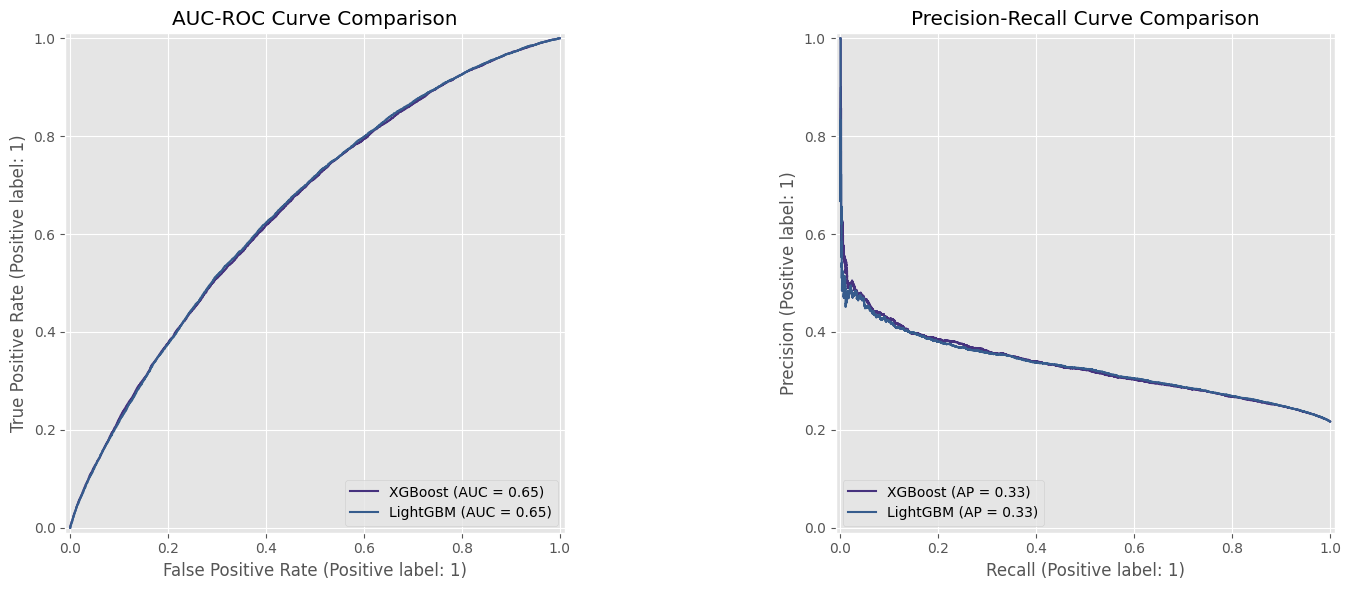

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test, ax=ax1, name='XGBoost')
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax1, name='LightGBM')
ax1.set_title('AUC-ROC Curve Comparison')

PrecisionRecallDisplay.from_estimator(best_xgb, X_test, y_test, ax=ax2, name='XGBoost')
PrecisionRecallDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax2, name='LightGBM')
ax2.set_title('Precision-Recall Curve Comparison')

plt.tight_layout()
plt.show()

## XGBoost vs LightGBM – ROC & Precision-Recall Comparison

This comparison evaluates two gradient boosting models—**XGBoost** and **LightGBM**—using threshold-independent metrics.

---

### ROC-AUC Comparison

**Observations:**
- **XGBoost AUC:** ~**0.65**
- **LightGBM AUC:** ~**0.65**
- ROC curves almost perfectly overlap

**Interpretation:**
- Both models have **identical ranking power**
- No meaningful difference in overall discrimination

---

### Precision–Recall Comparison

**Observations:**
- **Average Precision (AP):** ~**0.33** for both models
- Precision steadily declines as recall increases
- Curves overlap across all recall ranges

**Interpretation:**
- Class imbalance remains the primary challenge
- Both models behave similarly when optimizing for defaulter detection

---

### Business Takeaways

- Switching between boosting frameworks alone does **not yield performance gains**
- Improvements must come from:
  - Better feature interactions
  - Cost-sensitive objectives
  - Segment-level thresholding

---

### Conclusion

XGBoost and LightGBM demonstrate **equivalent performance** on this dataset. Model choice should therefore be guided by **training speed, interpretability, and deployment constraints**, rather than raw predictive power.


## 5. Feature Importance

<Figure size 1000x1200 with 0 Axes>

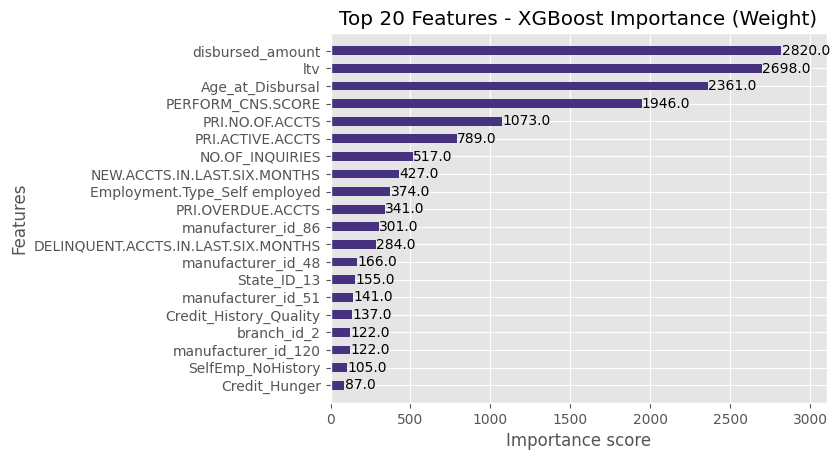

In [8]:
# plt.figure(figsize=(10, 12))
# plot_importance(best_xgb, max_num_features=20, height=0.5)
# plt.title('Top 20 Features - XGBoost Importance (Weight)')
# plt.show()
# 1. Get the feature names from your original training DataFrame (X_train)
best_xgb.get_booster().feature_names = list(X_train.columns)

# 2. Now run your plotting code
plt.figure(figsize=(10, 12))
plot_importance(best_xgb, max_num_features=20, height=0.5)
plt.title('Top 20 Features - XGBoost Importance (Weight)')
plt.show()

## XGBoost Feature Importance (Top 20)

This chart highlights the **top 20 most influential features** used by the XGBoost model, ranked by **split frequency (weight)**.

---

### Key Observations

- **Disbursed Amount** and **LTV** are the **strongest drivers**, reinforcing the importance of loan size and leverage
- **Age at Disbursal** and **Credit Bureau Score (PERFORM_CNS.SCORE)** are major borrower-level risk indicators
- **Credit activity features** (number of accounts, inquiries, delinquency history) contribute significantly
- **Employment type (Self-employed)** and **interaction features** appear among top predictors, validating multivariate risk effects
- **Operational features** (branch and manufacturer IDs) capture location- and asset-specific risk patterns

---

### Business Interpretation

- Default risk is driven by a **combination of loan structure, borrower profile, and credit behavior**
- Engineered interaction features add measurable predictive value
- Operational context (branch/manufacturer) materially affects outcomes

---

### Modeling Considerations

- Feature importance reflects **model usage**, not causal impact
- Highly correlated features (e.g., LTV & Disbursed Amount) should be monitored for stability
- Further explainability can be enhanced using SHAP values

---

### Conclusion

The feature importance analysis confirms that **leverage, loan size, credit history, and borrower stability** are the primary contributors to vehicle loan default risk, with interaction and operational features strengthening the model’s predictive power.


## Confusion Matrix Analysis
Displaying TN, FP, FN, TP for a clearer view of classification errors.

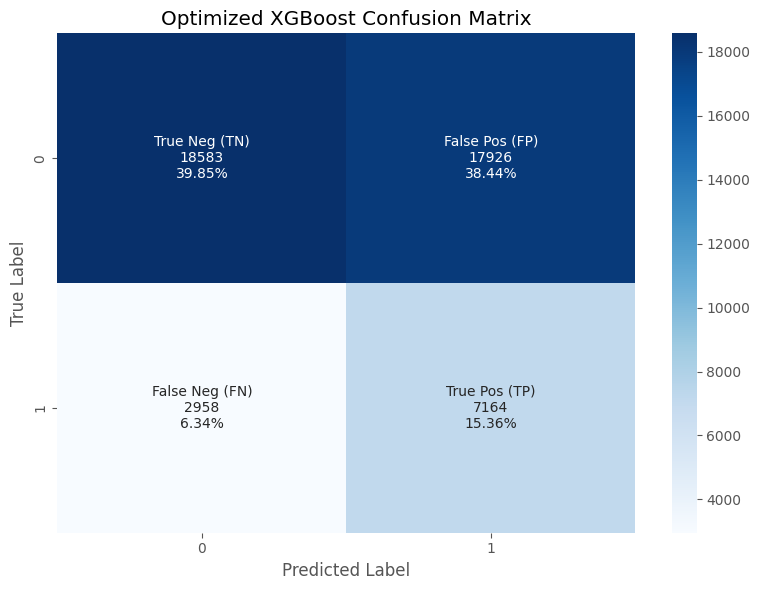

In [9]:
def plot_labeled_confusion_matrix(y_true, y_pred, title, ax):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg (TN)','False Pos (FP)','False Neg (FN)','True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, ax = plt.subplots(figsize=(8, 6))
plot_labeled_confusion_matrix(y_test, y_pred_opt, 'Optimized XGBoost Confusion Matrix', ax)
plt.tight_layout()
plt.show()

## Optimized XGBoost – Confusion Matrix Interpretation

This confusion matrix reflects the performance of the **tuned XGBoost model** at the **F1-optimized decision threshold**.

---

### Classification Breakdown

- **True Negatives (39.9%)**  
  Correctly identified non-defaulters

- **False Positives (38.4%)**  
  Safe borrowers incorrectly flagged as defaulters

- **False Negatives (6.3%)**  
  Defaulters missed by the model

- **True Positives (15.4%)**  
  Correctly identified defaulters

---

### Business Interpretation

- Model is **highly conservative toward risk**
- Majority of defaulters are successfully captured (low FN rate)
- High FP rate increases operational cost but **reduces credit losses**

---

### Trade-off Assessment

- **Low FN** → fewer risky loans slip through
- **High FP** → more manual reviews / rejections
- Suitable for **risk screening and early-warning systems**

---

### Conclusion

The optimized XGBoost model prioritizes **defaulter capture over approval rate**, making it effective for loss prevention. Final deployment should balance this trade-off using **business-specific cost thresholds or segment-based rules**.
